## BME680  
The Boshe BME680 is a gas sensor able to measure relative humidity, barometric pressure, ambient, temperature and volatile organic compound (VOC) gases.  

Manufacturer link: https://www.bosch-sensortec.com/products/environmental-sensors/gas-sensors-bme680/  
Breakout boards used:  
https://www.adafruit.com/product/3660  
https://www.sparkfun.com/products/14570

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from meerkat import bme680, parser, tools

Initialize sensor and get the onboard calibration values.

In [3]:
dev = bme680.BME680(bus_n=1)

In [4]:
dev.read_calibration()

Measurement steps, based on the datasheet section 3.2.1 Quickstart:
1. Set humidty oversample
2. Set temperature oversample
3. Set pressure oversample

In [5]:
dev.set_oversampling(h=1, t=2, p=16)

4. Set gas wait time with gas_wait_0 to 0x59 = 100ms

In [6]:
ms = 25
multiplier = 16
wait = dev.calc_wait_time(t=ms, x=multiplier)
print("Wait: {} ms".format(ms*multiplier))
print("code:", hex(wait))

Wait: 400 ms
code: 0x99


In [7]:
dev.set_gas_wait(n=0, value=wait)

5. Set heater set-point with res_heat_0, 150 C here

In [8]:
resistance = dev.calc_res_heat(target_temp=200)
resistance

177

In [9]:
dev.set_res_heat(n=0, value=resistance)

6. Set nb_conv to the 0 profile used in steps 4 and 5

In [10]:
dev.nb_conv = 0

7. Set run_gas to 1 to enable gas measurements

In [11]:
dev.gas_on()

8. Set mode to 0b01 to trigger a single forced mode measurement

In [12]:
%%time
dev.forced_mode()
dev.measure()
t = dev.temperature()
p = dev.pressure()
h = dev.humidity()
g = dev.gas()
print("T: ", t)
print("P: ", p)
print("RH:", h)
print("Gas Resistance:", g)
print("Gas Valid:", dev._gas_valid)
print("Heat Stable:", dev._heat_stab)

T:  20.2684765625
P:  1006.3151496935856
RH: 41.70648937305095
Gas Resistance: 3425
Gas Valid: 1
Heat Stable: 1
CPU times: user 19.8 ms, sys: 2.96 ms, total: 22.7 ms
Wall time: 444 ms


#### Measurement  

In [13]:
dev.get(description="test_1")

['test_1',
 1,
 22.2883984375,
 1006.2456444118999,
 41.976907465109235,
 3911,
 1,
 1]

In [14]:
dev.get(description="test_2", n=5)

[['test_2',
  1,
  23.571796875,
  1006.2667537143348,
  42.08894439288667,
  4222,
  1,
  1],
 ['test_2',
  2,
  24.2274609375,
  1006.3016993017569,
  42.0508952551473,
  4463,
  1,
  1],
 ['test_2', 3, 24.6503125, 1006.2805582327019, 41.88213366822671, 4671, 1, 1],
 ['test_2',
  4,
  24.941328125,
  1006.2679268209864,
  41.61725414247343,
  6848,
  1,
  1],
 ['test_2',
  5,
  25.1540234375,
  1006.3019738421577,
  41.31489737397977,
  7161,
  1,
  1]]

#### JSON Data Publishing  

In [15]:
# lower metadata interval from a default of once every 10 samples
dev.json_writer.metadata_interval = 3

In [16]:
dev.publish(description='test_3', n=7, delay=1)

['{"description": "test_3", "sample_n": 1, "T": 21.5012890625, "P": 1006.3337613762343, "RH": 39.65436588499878, "g_res": 7223, "g_val": 1, "heat_stab": 1, "std_time_ms": "2020-04-11 09:47:36.233474"}',
 '{"description": "test_3", "sample_n": 2, "T": 21.3544140625, "P": 1006.3136905093997, "RH": 39.19906166763091, "g_res": 7450, "g_val": 1, "heat_stab": 1, "std_time_ms": "2020-04-11 09:47:37.680689"}',
 '{"description": null, "sample_n": 3, "T": 21.2962109375, "P": 1006.3250874863975, "RH": 38.92510230468672, "g_res": 7683, "g_val": 1, "heat_stab": 1, "std_time_ms": "2020-04-11 09:47:39.130334", "name": "BME680", "title": null, "format": null, "encoding": "utf-8", "bytes": null, "hash": null, "schema": null, "sources": null, "licenses": null, "line_terminator": "\\n", "quote_char": "\\"", "double_quote": true, "escape_char": "\\\\", "null_sequence": "NA", "comment": "#", "skip_lines": 0, "path": null, "device": {"name": "BME680", "version_hw": "1.0", "version_sw": "1.0", "accuracy": nu

#### JSON Writer Output

In [18]:
# default writer format is CSV, switch to JSON
dev.writer_output = 'json'

In [19]:
# writer method with description and sample number
dev.write(description='test_3', n=30)

In [20]:
dev.json_writer.path

'2020_04_11_09_47_55.jsontxt'

In [21]:
with open(dev.json_writer.path, 'r') as f:
    for _ in range(4):
        print(f.readline().strip())

{"description": "test_3", "sample_n": 0, "T": 20.4329296875, "P": 1006.3168696496639, "RH": 39.847278690159186, "g_res": 7962, "g_val": 1, "heat_stab": 1, "std_time_ms": "2020-04-11 09:47:55.666078"}
{"description": "test_3", "sample_n": 1, "T": 22.764375, "P": 1006.1832675758951, "RH": 40.217338579602696, "g_res": 8470, "g_val": 1, "heat_stab": 1, "std_time_ms": "2020-04-11 09:47:56.115612"}
{"description": null, "sample_n": 2, "T": 23.9591015625, "P": 1006.2692171914123, "RH": 40.39673609038746, "g_res": 8831, "g_val": 1, "heat_stab": 1, "std_time_ms": "2020-04-11 09:47:56.563932", "name": "BME680", "title": null, "format": null, "encoding": "utf-8", "bytes": null, "hash": null, "schema": null, "sources": null, "licenses": null, "line_terminator": "\n", "quote_char": "\"", "double_quote": true, "escape_char": "\\", "null_sequence": "NA", "comment": "#", "skip_lines": 0, "path": "2020_04_11_09_47_55.jsontxt", "device": {"name": "BME680", "version_hw": "1.0", "version_sw": "1.0", "accu

#### CSV Writer Output

In [22]:
# switch back to CSV format
dev.writer_output = 'csv'

In [23]:
# writer method with description and sample number
dev.write(description='test_4', n=30, delay=1)

In [24]:
dev.csv_writer.path

'2020_04_11_09_48_18_data.csv'

In [25]:
# load .csv data written with dev.write
m, df = parser.csv_resource(dev.csv_writer.path)

#### Metadata in CSV

In [26]:
m

{'name': 'BME680',
 'title': None,
 'description': None,
 'format': None,
 'encoding': 'utf-8',
 'bytes': None,
 'hash': None,
 'schema': None,
 'sources': None,
 'licenses': None,
 'line_terminator': '\n',
 'quote_char': '"',
 'double_quote': True,
 'escape_char': '\\',
 'null_sequence': 'NA',
 'comment': '#',
 'skip_lines': 1,
 'path': '2020_04_11_09_48_18_data.csv',
 'device': {'name': 'BME680',
  'version_hw': '1.0',
  'version_sw': '1.0',
  'accuracy': None,
  'precision': 'VOC:0.08%, RH:0.01%, P:0.02Pa, T:1.0C',
  'bus': '<meerkat.i2c_pi.WrapI2C object at 0xacfb80b0>',
  'state': None,
  'active': None,
  'error': None,
  'dtype': None,
  'description': 'Bosch Humidity, Pressure, Temperature, VOC Sensor',
  'urls': 'https://www.bosch-sensortec.com/products/environmental-sensors/gas-sensors-bme680/',
  'manufacturer': 'Bosch Sensortec',
  'calibration_date': None},
 'units': None,
 'dtypes': None,
 'accuracy': None,
 'precision': None,
 'time_format': 'std_time_ms',
 'strfmtime': 

#### Parsed CSV data

In [27]:
df.head()

,std_time_ms,description,sample_n,T,P,RH,g_res,g_val,heat_stab,datetime64_ns
0,2020-04-11 09:48:18.848623,test_4,0,20.762031,1006.313300,36.403714,13823,1,1,2020-04-11 09:48:18.848623
1,2020-04-11 09:48:20.299945,test_4,1,21.245625,1006.309198,36.905102,14013,1,1,2020-04-11 09:48:20.299945
2,2020-04-11 09:48:21.744936,test_4,2,21.367109,1006.331722,37.130844,14248,1,1,2020-04-11 09:48:21.744936
3,2020-04-11 09:48:23.191516,test_4,3,21.417695,1006.317877,37.248512,14438,1,1,2020-04-11 09:48:23.191516
4,2020-04-11 09:48:24.641131,test_4,4,21.440547,1006.316423,37.312785,14559,1,1,2020-04-11 09:48:24.641131


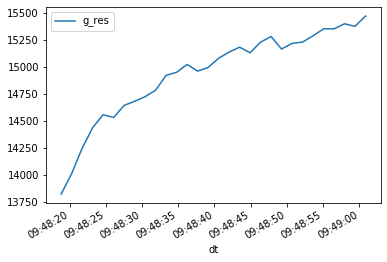

In [28]:
df["dt"] = pd.to_datetime(df.std_time_ms)
df[["dt", "g_res"]].plot(x="dt");

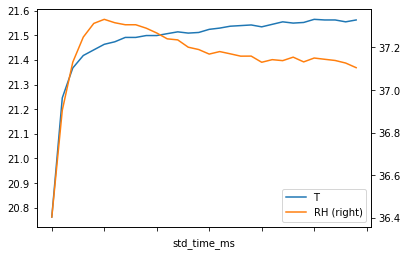

In [29]:
df[["std_time_ms", "T", "RH"]].plot(x="std_time_ms", secondary_y="RH");

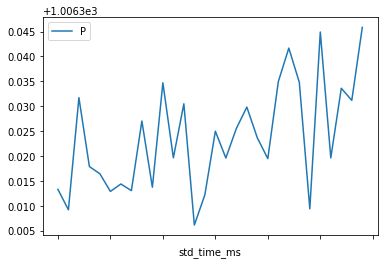

In [30]:
df[["std_time_ms", "P"]].plot(x="std_time_ms");